# FINA4350 Final Project

### Team Members: Priya Aggarwal, Chris Burke, Manuel Eduque

In [1]:
# all imports used in notebook
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import statsmodels.api as sm
import yahoo_fin.stock_info as si
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import norm
from arch import arch_model
import statistics

warnings.filterwarnings('ignore')

# Part I. Stock Selection

In [2]:
# start by reading in the constituents financials data 
constituents_financials = pd.read_csv("constituents-financials_csv.csv")
constituents_financials.head()

,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings
0,MMM,3M Company,Industrials,222.89,24.31,2.332862,7.92,259.77,175.490,138721055226,9.048000e+09,4.390271,11.34,http://www.sec.gov/cgi-bin/browse-edgar?action...
1,AOS,A.O. Smith Corp,Industrials,60.24,27.76,1.147959,1.70,68.39,48.925,10783419933,6.010000e+08,3.575483,6.35,http://www.sec.gov/cgi-bin/browse-edgar?action...
2,ABT,Abbott Laboratories,Health Care,56.27,22.51,1.908982,0.26,64.60,42.280,102121042306,5.744000e+09,3.740480,3.19,http://www.sec.gov/cgi-bin/browse-edgar?action...
3,ABBV,AbbVie Inc.,Health Care,108.48,19.41,2.499560,3.29,125.86,60.050,181386347059,1.031000e+10,6.291571,26.14,http://www.sec.gov/cgi-bin/browse-edgar?action...
4,ACN,Accenture plc,Information Technology,150.51,25.47,1.714470,5.44,162.60,114.820,98765855553,5.643228e+09,2.604117,10.62,http://www.sec.gov/cgi-bin/browse-edgar?action...


## Calculation of Recent 30 Day Returns:

In [3]:
# initialize list of returns
stock_returns = []
stock_stdevs = []

# calculate 30-day returns for each stock in our portfolio
for stock_ticker in constituents_financials['Symbol']:
    # try to get the financial data for the current stock if available
    try:
        price_data = si.get_data(stock_ticker)
        # calculate returns over the last 30 days
        price_today = price_data.adjclose[-1]
        price_one_month = price_data.adjclose[-20] # 20-day offset represents 5-business days x 4-weeks
        thirty_day_return = round(((price_today - price_one_month) / price_one_month) * 100, 2)
        
        # calculate daily returns and their standard deviation
        daily_rets = price_data.adjclose.pct_change().dropna()[-20:]  # last 20 trading days
        stdev_daily_returns = round(statistics.stdev(daily_rets) * 100, 2)
        
        # add the thirty day return and its standard deviation to the lists
        stock_stdevs.append(stdev_daily_returns)
        stock_returns.append(thirty_day_return)
        
    # catch the case where the stock is no longer active and add a null value to the 30 day returns
    except:
        stock_returns.append(None)
        stock_stdevs.append(None)

# add the thirty day return to the stock's entry
constituents_financials['30 Day Return'] = stock_returns
constituents_financials['30 Day STDEV'] = stock_stdevs

# view our dataset again to ensure properly added returns
constituents_financials

,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings,30 Day Return,30 Day STDEV
0,MMM,3M Company,Industrials,222.89,24.31,2.332862,7.92,259.77,175.490,138721055226,9.048000e+09,4.390271,11.34,http://www.sec.gov/cgi-bin/browse-edgar?action...,9.69,1.24
1,AOS,A.O. Smith Corp,Industrials,60.24,27.76,1.147959,1.70,68.39,48.925,10783419933,6.010000e+08,3.575483,6.35,http://www.sec.gov/cgi-bin/browse-edgar?action...,4.55,1.15
2,ABT,Abbott Laboratories,Health Care,56.27,22.51,1.908982,0.26,64.60,42.280,102121042306,5.744000e+09,3.740480,3.19,http://www.sec.gov/cgi-bin/browse-edgar?action...,9.89,0.88
3,ABBV,AbbVie Inc.,Health Care,108.48,19.41,2.499560,3.29,125.86,60.050,181386347059,1.031000e+10,6.291571,26.14,http://www.sec.gov/cgi-bin/browse-edgar?action...,11.00,0.80
4,ACN,Accenture plc,Information Technology,150.51,25.47,1.714470,5.44,162.60,114.820,98765855553,5.643228e+09,2.604117,10.62,http://www.sec.gov/cgi-bin/browse-edgar?action...,7.09,0.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,XYL,Xylem Inc.,Industrials,70.24,30.94,1.170079,1.83,76.81,46.860,12915021000,7.220000e+08,2.726209,5.31,http://www.sec.gov/cgi-bin/browse-edgar?action...,7.01,0.89
501,YUM,Yum! Brands Inc,Consumer Discretionary,76.30,27.25,1.797080,4.07,86.93,62.850,27003303098,2.289000e+09,6.313636,212.08,http://www.sec.gov/cgi-bin/browse-edgar?action...,0.90,0.92
502,ZBH,Zimmer Biomet Holdings,Health Care,115.53,14.32,0.794834,9.01,133.49,108.170,24454698119,2.007400e+09,3.164895,2.39,http://www.sec.gov/cgi-bin/browse-edgar?action...,8.68,0.95
503,ZION,Zions Bancorp,Financials,50.71,17.73,1.480933,2.60,55.61,38.430,10670678640,0.000000e+00,3.794579,1.42,http://www.sec.gov/cgi-bin/browse-edgar?action...,7.80,2.98


In [4]:
# Drop all of the rows with null values. This takes out all the rows that yahoo finance could not draw data frame as 
# well as a couple more rows that we are missing pieces of data for.
constituents_financials.dropna(subset=['30 Day Return', 'Price/Earnings', 'Price/Book', '30 Day STDEV'], inplace=True)

In [5]:
constituents_financials.isnull().sum()

Symbol            0
Name              0
Sector            0
Price             0
Price/Earnings    0
Dividend Yield    0
Earnings/Share    0
52 Week Low       0
52 Week High      0
Market Cap        0
EBITDA            0
Price/Sales       0
Price/Book        0
SEC Filings       0
30 Day Return     0
30 Day STDEV      0
dtype: int64

## OLS Model:

In [6]:
# create subset of only the columns we want in our OLS model (relevant categorical/numerical columns)
# We choose not to include 52 Week Low and 52 Week High since this dataset is a couple years old and these values would no longer be helpful
variables_to_keep = ['Sector', 'Price/Earnings', 'Dividend Yield', 'Earnings/Share', 'Market Cap', 'EBITDA', 'Price/Sales', 'Price/Book', '30 Day Return']
df_ols = constituents_financials[variables_to_keep]

In [7]:
# create dummy variables for the categorical variable (sector)
df_ols = pd.get_dummies(df_ols, columns=['Sector'], prefix=['sector'])

# the sector utilities was dropped out of the dummy variables, meaning that the interpretation of the intercept 
# would be a stock that is within the utilities sector
df_ols = df_ols.drop('sector_Utilities', axis=1)
print(df_ols.columns)

Index(['Price/Earnings', 'Dividend Yield', 'Earnings/Share', 'Market Cap',
       'EBITDA', 'Price/Sales', 'Price/Book', '30 Day Return',
       'sector_Consumer Discretionary', 'sector_Consumer Staples',
       'sector_Energy', 'sector_Financials', 'sector_Health Care',
       'sector_Industrials', 'sector_Information Technology',
       'sector_Materials', 'sector_Real Estate',
       'sector_Telecommunication Services'],
      dtype='object')


array([[<Axes: title={'center': 'Price/Earnings'}>,
        <Axes: title={'center': 'Dividend Yield'}>,
        <Axes: title={'center': 'Earnings/Share'}>],
       [<Axes: title={'center': 'Market Cap'}>,
        <Axes: title={'center': 'EBITDA'}>,
        <Axes: title={'center': 'Price/Sales'}>],
       [<Axes: title={'center': 'Price/Book'}>,
        <Axes: title={'center': '30 Day Return'}>, <Axes: >]],
      dtype=object)

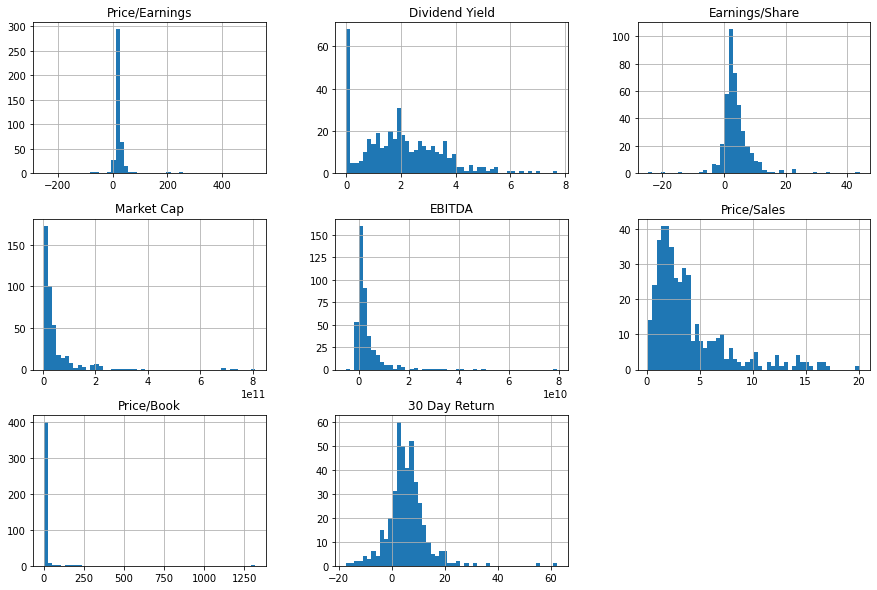

In [8]:
# Look at histograms for all the numeric variables in the dataframe
df_ols.hist(bins=50, figsize=(15, 10))

After looking at the histograms for all the numeric features within our OLS, we decided to logarithmically transform the following variables to make them more normally distributed: Market cap, EBITDA, Price/Sales, Price/Book.

We also need to create a floor value of 0 for many of them, since the log of a negative number is undefined. This will be done for the EBITDA column.

In [9]:
minimum = df_ols['EBITDA'].min()
df_ols['EBITDA_shifted'] = np.add(np.add(df_ols['EBITDA'], abs(minimum)), 0.0001)

In [10]:
df_ols['ln_market_cap'] = np.log(df_ols['Market Cap'])
df_ols['ln_EBITDA'] = np.log(df_ols['EBITDA_shifted'])
df_ols['ln_price/sales'] = np.log(df_ols['Price/Sales'])
df_ols['ln_price/book'] = np.log(df_ols['Price/Book'])

array([[<Axes: title={'center': 'Price/Earnings'}>,
        <Axes: title={'center': 'Dividend Yield'}>,
        <Axes: title={'center': 'Earnings/Share'}>,
        <Axes: title={'center': 'Market Cap'}>],
       [<Axes: title={'center': 'EBITDA'}>,
        <Axes: title={'center': 'Price/Sales'}>,
        <Axes: title={'center': 'Price/Book'}>,
        <Axes: title={'center': '30 Day Return'}>],
       [<Axes: title={'center': 'EBITDA_shifted'}>,
        <Axes: title={'center': 'ln_market_cap'}>,
        <Axes: title={'center': 'ln_EBITDA'}>,
        <Axes: title={'center': 'ln_price/sales'}>],
       [<Axes: title={'center': 'ln_price/book'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

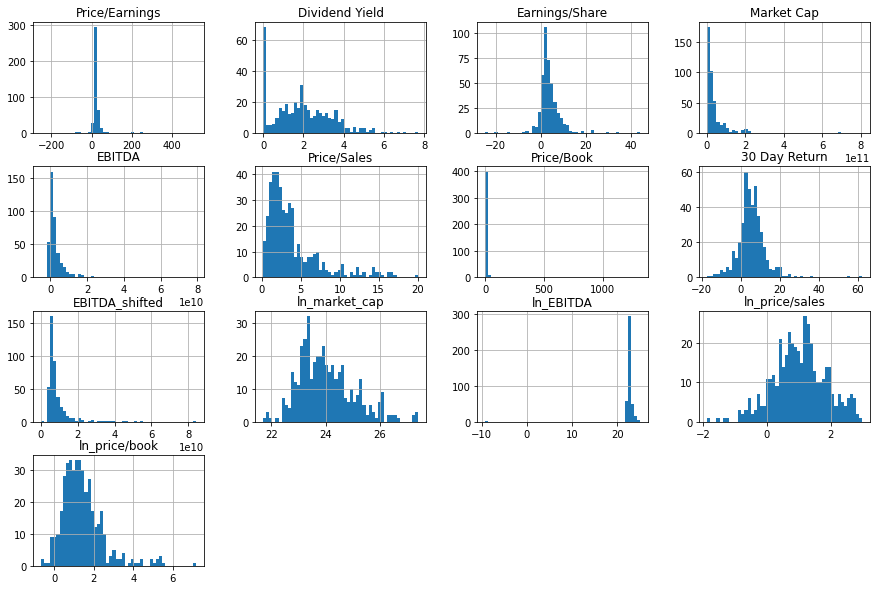

In [11]:
df_ols.hist(bins=50, figsize=(15, 10))

In [12]:
# create our x and y dataframes
X = df_ols.drop('30 Day Return', axis=1)
X = X.drop('Market Cap', axis=1)
X = X.drop('EBITDA', axis=1)
X = X.drop('Price/Sales', axis=1)
X = X.drop('Price/Book', axis=1)

y = constituents_financials['30 Day Return']

In [13]:
# store the names of the variables
feature_names = list(X.columns)
print(feature_names)

['Price/Earnings', 'Dividend Yield', 'Earnings/Share', 'sector_Consumer Discretionary', 'sector_Consumer Staples', 'sector_Energy', 'sector_Financials', 'sector_Health Care', 'sector_Industrials', 'sector_Information Technology', 'sector_Materials', 'sector_Real Estate', 'sector_Telecommunication Services', 'EBITDA_shifted', 'ln_market_cap', 'ln_EBITDA', 'ln_price/sales', 'ln_price/book']


In [14]:
# we add a variable that is a constant.
X = sm.add_constant(X)

# Run the OLS model
model = sm.OLS(y, X.astype(float))
results = model.fit()
results.summary(xname=['intercept'] + feature_names)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          30 Day Return   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     5.422
Date:                Wed, 13 Dec 2023   Prob (F-statistic):           2.11e-11
Time:                        13:33:55   Log-Likelihood:                -1405.2
No. Observations:                 421   AIC:                             2848.
Df Residuals:                     402   BIC:                             2925.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
intercept                             2.5710     12.376      0.208      0.836     -21.758      26.900
Price/Earnings                        0.0029      0.009      0.332      0.740      -0.014       0.020
Dividend Yield                        0.7137      0.313      2.278      0.023       0.098       1.330
Earnings/Share                       -0.0273      0.076     -0.360      0.719      -0.177       0.122
sector_Consumer Discretionary         7.2854      1.778      4.097      0.000       3.789      10.781
sector_Consumer Staples               2.0125      1.993      1.010      0.313      -1.906       5.931
sector_Energy                        -7.6015      2.108     -3.606      0.000     -11.746      -3.457
sector_Financials                     5.5539      1.761      3.154      0.002       2.092       9.016
sector_Health Care                    5.4853      1.918      2.860      0.004       1.716       9.255
sector_Industrials                    4.8599      1.847      2.631      0.009       1.229       8.491
sector_Information Technology         4.8159      1.844      2.612      0.009       1.191       8.441
sector_Materials                      1.3009      2.119      0.614      0.540      -2.864       5.466
sector_Real Estate                    3.6845      2.021      1.823      0.069      -0.288       7.658
sector_Telecommunication Services     5.1662      5.720      0.903      0.367      -6.079      16.411
EBITDA_shifted                    -1.007e-10    7.5e-11     -1.342      0.180   -2.48e-10    4.68e-11
ln_market_cap                        -0.1584      0.506     -0.313      0.754      -1.153       0.836
ln_EBITDA                             0.1302      0.228      0.571      0.568      -0.318       0.579
ln_price/sales                       -0.0981      0.556     -0.176      0.860      -1.192       0.996
ln_price/book                        -0.3326      0.393     -0.845      0.398      -1.106       0.441
==============================================================================
Omnibus:                      208.898   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2601.305
Skew:                           1.796   Prob(JB):                         0.00
Kurtosis:                      14.636   Cond. No.                     4.21e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.21e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Axes: ylabel='Count'>

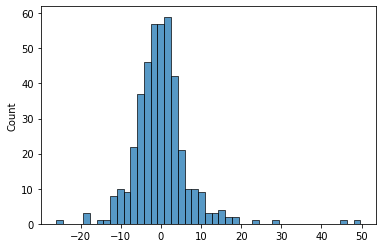

In [15]:
# check if the residuals look normally distributed around 0
residuals = y - results.predict(X)
sns.histplot(residuals)

## Analysis of OLS Model and Selection of Characteristics:
The r-squared of our OLS model for predicting 30 Day Returns based on stock metrics was 0.195. This metric makes sense in the context of predicting recent stock returns based on (outdated) characteristics of a stock such as P/E ratio and its sector, since it is very difficult to predict returns with accuracy. The residuals of this model were also normally distributed which validated some of the assumptions of the OLS model and showed that we have largely explained the variance in y with x that we could realistically predict. It is important to note that when talking about the features that many of them were transformed to be more normally distributed and the coefficients reflect that.


Selection of Characteristic’s our portfolio is based on:

Sectors such as Consumer Discretionary, Energy, Healthcare and Financials demonstrated significance with the lowest p-values, well below the 5% threshold.

When comparing these sectors, we focused on the coefficient values. According to our OLS model, the Energy Sector presented a negative coefficient at -7.6015, indicating an association with a decrease in the expected 30-day returns compared to other sectors. Consequently, we omitted this sector from further consideration. Between the remaining sectors, Consumer Discretionary had the highest positive coefficient at 7.2854, in contrast to Financials and Healthcare, which has coefficients of 5.5539 and 5.4853 respectively. This suggests that stocks in the Consumer Discretionary Sector could experience higher 30-day returns compared to other sectors. Unfortunately, due to the outdated dataset we refrained from putting analytical significance to other quantitative characteristics such as P/E ratio, P/S ratio, EBITDA, market capitalization, etc. Based on the OLS model results, this is okay as the characteristics other than sector presented lower coefficients and higher p-values, indicating less statistical impact on the 30-day return values.

Therefore, our focus shifted to stocks within the Consumer Discretionary Sector, which also exhibited the highest level of significance in terms of the lowest p-value. This decision aligns with the portfolio's objective of realizing high 30-day returns, particularly during the month of December, where this sector is anticipated to benefit from increased holiday spending.


In [16]:
pd.set_option("display.max_rows", None)

consumer_discretionary = constituents_financials[constituents_financials['Sector'] == 'Consumer Discretionary']
consumer_discretionary.reset_index().head()

,index,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings,30 Day Return,30 Day STDEV
0,8,AAP,Advance Auto Parts,Consumer Discretionary,109.63,19.54,0.218321,6.19,169.55,78.81,8123611867,8.539410e+08,1.130106,2.51,http://www.sec.gov/cgi-bin/browse-edgar?action...,-3.68,3.67
1,30,AMZN,Amazon.com Inc,Consumer Discretionary,1350.50,296.16,0.000000,6.16,1498.00,812.50,685873374731,1.613200e+10,3.927053,24.28,http://www.sec.gov/cgi-bin/browse-edgar?action...,1.15,1.26
2,53,APTV,Aptiv Plc,Consumer Discretionary,89.27,69.74,0.939268,5.05,96.91,82.97,24906530300,2.370000e+09,1.502580,7.56,http://www.sec.gov/cgi-bin/browse-edgar?action...,1.30,1.71
3,61,AZO,AutoZone Inc,Consumer Discretionary,718.57,16.31,0.000000,44.09,797.89,491.13,19922021415,2.347304e+09,1.851043,136.23,http://www.sec.gov/cgi-bin/browse-edgar?action...,-0.87,1.21
4,71,BBY,Best Buy Co. Inc.,Consumer Discretionary,68.79,19.22,1.908504,3.81,78.59,41.67,20831186176,2.555000e+09,0.767155,4.79,http://www.sec.gov/cgi-bin/browse-edgar?action...,11.51,1.88


## Stock Selection:

The below stocks have been chosen from the Consumer Discretionary sector. Our thesis is that these stocks will do well in Q4 of the current year due to increased holiday spending. Within the sector, each stock was chosen based on whether we believe the company sells products that consumers are most likely to purchase as gifts.

Company: Ticker
- Mattel Inc.: MAT
- Hasbro Inc.: HAS
- Macy's Inc.: M
- TJX Companies Inc.: TJX
- Nordstrom: JWN
- Ulta Salon Cosmetics & Fragrance Inc: ULTA
- Signet Jewelers: SIG
- Amazon.com Inc: AMZN
- Marriott Int'l: MAR
- General Motors: GM
    
The selected stocks represent a mixture of jewelry & fashion retailers, toy manufacturers, e-commerce platforms, department stores, a hotel & resort brand, and a car manufacturer. This represents an underlying diversified approach within the Consumer Discretionary sector, giving our portfolio the best chance of investment growth.

Note: We intentionally refrained from selecting our stocks using any quantitative values from the `constituents-financials-csv` dataset since this data is outdated by approximately three years. We want to avoid making predictions today based on outdated data.

In [17]:
# create dataframe of only the stocks in our portfolio
portfolio_tickers = ['MAT', 'HAS', 'M', 'TJX', 'JWN', 'ULTA', 'SIG', 'AMZN', 'MAR', 'GM']
portfolio_stocks = consumer_discretionary[consumer_discretionary["Symbol"].isin(portfolio_tickers)].reset_index()
portfolio_stocks

,index,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings,30 Day Return,30 Day STDEV
0,30,AMZN,Amazon.com Inc,Consumer Discretionary,1350.50,296.16,0.000000,6.16,1498.00,812.5000,685873374731,1.613200e+10,3.927053,24.28,http://www.sec.gov/cgi-bin/browse-edgar?action...,1.15,1.26
1,212,GM,General Motors,Consumer Discretionary,40.75,6.58,3.585751,6.00,46.76,31.9200,61536606173,2.354100e+10,0.563322,1.33,http://www.sec.gov/cgi-bin/browse-edgar?action...,18.85,2.55
2,224,HAS,Hasbro Inc.,Consumer Discretionary,96.48,20.57,2.230483,4.34,116.20,87.9200,12732072001,1.028425e+09,3.237568,5.82,http://www.sec.gov/cgi-bin/browse-edgar?action...,7.20,2.15
3,291,M,Macy's Inc.,Consumer Discretionary,24.00,7.67,6.098546,1.98,33.73,17.4050,7541063495,2.446000e+09,0.455032,1.69,http://www.sec.gov/cgi-bin/browse-edgar?action...,62.40,5.90
4,294,MAR,Marriott Int'l.,Consumer Discretionary,133.88,32.73,0.945288,2.67,149.21,85.3725,50910130358,2.620000e+09,2.999725,11.02,http://www.sec.gov/cgi-bin/browse-edgar?action...,7.44,1.57
5,299,MAT,Mattel Inc.,Consumer Discretionary,16.00,-14.68,0.000000,-3.06,26.30,12.7100,5843402350,-2.035990e+08,1.186372,3.87,http://www.sec.gov/cgi-bin/browse-edgar?action...,-1.06,1.61
6,337,JWN,Nordstrom,Consumer Discretionary,47.23,15.04,3.002029,2.02,53.00,37.7924,8212509855,1.448000e+09,0.746034,9.10,http://www.sec.gov/cgi-bin/browse-edgar?action...,18.04,4.25
7,412,SIG,Signet Jewelers,Consumer Discretionary,49.38,6.65,2.473075,7.03,77.94,46.0900,3034275549,8.527000e+08,0.756470,1.38,http://www.sec.gov/cgi-bin/browse-edgar?action...,20.63,3.77
8,446,TJX,TJX Companies Inc.,Consumer Discretionary,74.36,21.01,1.640420,3.46,81.46,66.4400,48181450881,4.600216e+09,1.929360,10.35,http://www.sec.gov/cgi-bin/browse-edgar?action...,-1.44,1.15
9,457,ULTA,Ulta Salon Cosmetics & Fragrance Inc,Consumer Discretionary,209.09,32.07,0.000000,6.52,314.86,187.9600,13300000127,1.002093e+09,3.377911,8.04,http://www.sec.gov/cgi-bin/browse-edgar?action...,23.90,2.81


# Part II. Visualization of Portfolio

### Visualizations Table of Contents:
1. Barplot of all characteristics By Individual Stock
2. Result of `$10,000` invested 30 days ago &#8594; Portfolio vs Market (S&P 500)
3. Barplot of Individual Stock's Daily Returns
4. Portfolio Summarizing Table with Standard Deviation Over Last 30 Days

## Visualization 1:

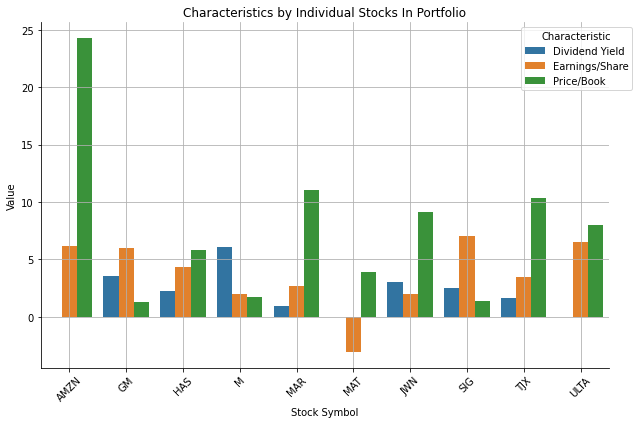

In [18]:
barplot_data = portfolio_stocks.melt(id_vars=['Symbol'], 
                                    value_vars=['Dividend Yield', 'Earnings/Share', 'Price/Book'],
                                    var_name='Metric', value_name='Value')

g = sns.catplot(data=barplot_data, kind='bar', x='Symbol', y='Value', hue='Metric', height=6, aspect=1.5, legend=False)

plt.title('Characteristics by Individual Stocks In Portfolio')
plt.ylabel('Value')
plt.xlabel('Stock Symbol')
plt.xticks(rotation=45)  
plt.legend(title='Characteristic', loc='upper right', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.grid()
plt.show()

Our first visualization is a barplot which provides a visual comparison of dividend yield, earnings per share, and price/book ratio for the 10 stocks in our portfolio. 

- Dividend Yield: The percentage of a company’s share price that is paid out as dividends annually
- EPS: The portion of a company’s profit allocated to each outstanding share of common stock
- P/B ratio: A ratio comparing the market value of a company’s shares to the book value of its equity.

Providing investors with a quick snapshot of the potential income (via dividends), company profitability, and stock valuation of individual stocks in this portfolio.

 ## Visualization 2:

In [19]:
# get only adjusted close stock data of sp500 and each stock in portfolio
sp500_data = si.get_data('^GSPC').loc['2023-11-13':'2023-12-13'][['adjclose']]

# calculate value of $10,000
sp500_data
sp500_multiplier = 10000/sp500_data['adjclose'].iloc[0]
sp500_value = np.multiply(sp500_data, sp500_multiplier)
sp500_value.head()

,adjclose
2023-11-13,10000.000000
2023-11-14,10190.750177
2023-11-15,10207.024928
2023-11-16,10219.175650
2023-11-17,10232.277135


In [20]:
# iterate through each of the stocks' tickers in our portfolio
for stock_ticker in portfolio_tickers:
    
    # get adjusted close data for the current stock and calculate value of $1000 over time
    stock_data = si.get_data(stock_ticker).loc['2023-11-13':'2023-12-13'][['adjclose']]
    stock_multiplier = 1000/stock_data['adjclose'].iloc[0]
    stock_value = np.multiply(stock_data, stock_multiplier)
    
    # if the first stock is being added to the portfolio, set the portfolio equal to the first stock
    if (stock_ticker == 'MAT'):
        portfolio_value = stock_value
    
    # otherwise add the next stock to the portfolio
    else:
        portfolio_value = np.add(portfolio_value, stock_value)

# at this point, the portfolio should now have $10,000 invested in total, $1000 from each stock
portfolio_value.head()

,adjclose
2023-11-13,10000.000000
2023-11-14,10516.520937
2023-11-15,10729.779044
2023-11-16,10580.393452
2023-11-17,10828.275660


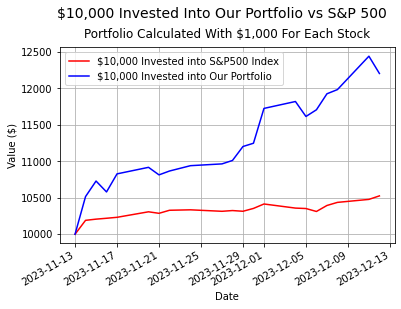

In [21]:
# plot $10,000 invested into each of our portfolio and the SP500 over the past 30 days
fig, ax = plt.subplots()
ax.plot(sp500_value, color = 'red', label = '$10,000 Invested into S&P500 Index')
ax.plot(portfolio_value, color = 'blue', label = '$10,000 Invested into Our Portfolio')
fig.suptitle('$10,000 Invested Into Our Portfolio vs S&P 500', fontsize=14, y=1.02)
ax.set_title('Portfolio Calculated With $1,000 For Each Stock', fontsize=12, y=1.02)
ax.set_xlabel('Date')
ax.set_ylabel('Value ($)')
fig.autofmt_xdate()
ax.grid(True)
ax.legend()
fig.show()

For the second visualization, we simulated what a \\$10,000 investment made 30 days ago would look like in the S\&P 500 compared to if we invested \\$1,000 into each of the 10 stocks that make up our portfolio. The ending value of our portfolio (i.e. the value today) would be \\$12,205.72, and the end value of an investment into the S\&P 500 would be \\$10,526.23. The ROI for each investment respectively would be 22.06% for our portfolio and 5.26% in the broader market.

Our portfolio outperformed the S&P 500 over the last 30 days in large part due to the 62.4% return on Macy’s stock. Macy’s has received a $5.8 billion dollar buyout offer which significantly raised the value of each share. This should be kept in mind when investing into our portfolio as a portion of the gains have come in the form of a one-time event creating an increase in volatility.

## Visualization 3:

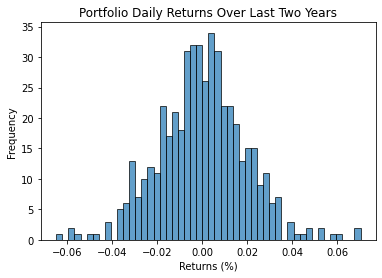

In [22]:
start_date = '01/01/2022'
end_date = '12/13/2023'

portfolio_returns = pd.DataFrame()

for i in range(len(portfolio_tickers)):
    stock = portfolio_tickers[i]
    stock_prices = si.get_data(stock, start_date, end_date)['adjclose']
    daily_returns = stock_prices.pct_change()
    weighted_returns = daily_returns * 0.1
    portfolio_returns[stock] = weighted_returns

portfolio_returns['Portfolio'] = portfolio_returns.sum(axis=1)

plt.hist(portfolio_returns['Portfolio'].dropna(), bins=50, edgecolor='black', alpha=0.7)
plt.title('Portfolio Daily Returns Over Last Two Years')
plt.xlabel('Returns (%)')
plt.ylabel('Frequency')
plt.show()

For the third visualization, we plotted a histogram of daily returns from the past 2 years of the collective portfolio. For the most part, this histogram is normally distributed around 0% percentage return. For the histogram bars that reflect higher returns for the portfolio, this tended to be days within the last quarter of the year, similar to the timeframe we are suggesting to invest in our portfolio.

## Portfolio Summarizing Table

In [23]:
columns_to_keep = ['Symbol','Name', 'Sector','Dividend Yield'
                   , 'Earnings/Share', 'Price/Book', '30 Day Return','30 Day STDEV']

display_table = [columns_to_keep]

# display table
display_table

[['Symbol',
  'Name',
  'Sector',
  'Dividend Yield',
  'Earnings/Share',
  'Price/Book',
  '30 Day Return',
  '30 Day STDEV']]

This table summarizes the key metrics of our 10 stocks in the portfolio. Besides dividend yield, EPS, P/B ratio and 30 day returns which we showed in our above graphs, we chose to include the standard deviation of each stock’s 30 day returns as well. The Standard Deviation of 30-day returns in the provided data shows the volatility of each stock's returns over the past 30 days. A higher standard deviation indicates that the stock's returns have fluctuated more widely from the average, suggesting higher volatility and potentially higher risk. Conversely, a lower standard deviation suggests that the stock's returns have been more consistent and less volatile. This metric is useful for investors to understand the risk profile of each stock in the context of short-term price movements.

# Part III. Simulation of Portfolio Performance

### Monte Carlo and Brownian Motion Simulations

In [24]:
def calc_monte_carlo(data, last_years_data, ticker, iteration, individual_stock, periods=30):
    # create log returns and calculate the mean, standard deviation, and variance of returns
    log_returns = np.log(1 + last_years_data.pct_change())
    mean = log_returns.mean()

    basic_gm = arch_model(log_returns.dropna(), p=1, q=1, 
                      mean='constant', vol='GARCH', dist='normal')
    gm_forecast = basic_gm.fit(disp = 0).forecast(horizon=30)
    gm_variance = gm_forecast.variance
    
    variance = gm_variance.mean(axis=1)[0]
    stddev = np.sqrt(variance)

    # calculate the drift term using brownian motion formula - brownian motion uses last year's price action
    drift = mean - (0.5 * variance)

    # create 1000 iterations/simulations. In each, draw 30 standard normal variables
    # this represents the simulation in price over the next 30 days
    np.random.seed(seed=iteration) # change seed to new value for each individual stock
                               # otherwise the same "randomness" will exist in every simulation
    z = norm.ppf(np.random.rand(periods, 1000))

    # create the return based on the above
    returns = drift.values + stddev * z

    # recreate returns from the log normal model
    daily_returns = np.exp(returns)

    # create prices from returns
    price_list = np.zeros_like(daily_returns)
    if individual_stock:
        S0 = data.iloc[-1] # This will start with today's most recent starting price
        price_list[0] = S0
    else:
        price_list[0] = 10000 # This is for portfolio's of 10000 dollars value

    # loop 30 times to place the next day's predicted price in our model
    for t in range(1, periods):
        price_list[t] = price_list[t-1] * daily_returns[t]

    #simulate 1 draw 
    plt.plot(pd.DataFrame(price_list).iloc[:, 0:1], color=colors[iteration]);
    if not individual_stock:
        plt.title('Portfolio Value: 10,000')
    plt.suptitle(f'{ticker} Monte Carlo Simulaton for Next 30 Days')
    plt.xlabel('Days From Today')
    plt.ylabel('Value ($)')
    plt.grid()
    plt.show()
    
    max=round(pd.DataFrame(price_list).iloc[-1].quantile(.95), 2)
    min=round(pd.DataFrame(price_list).iloc[-1].quantile(.05), 2)
    return min, max

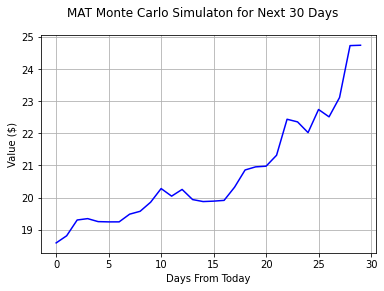

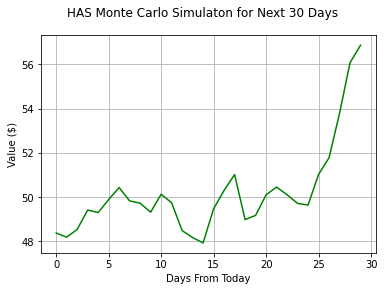

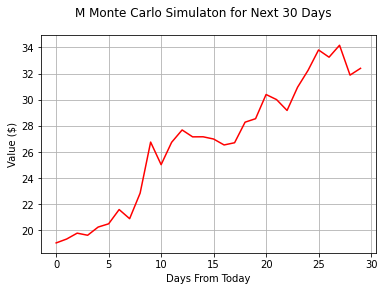

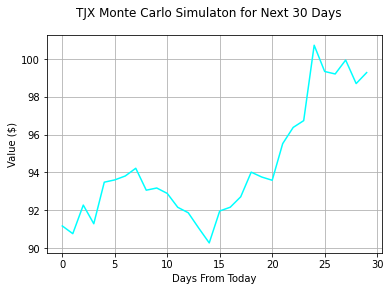

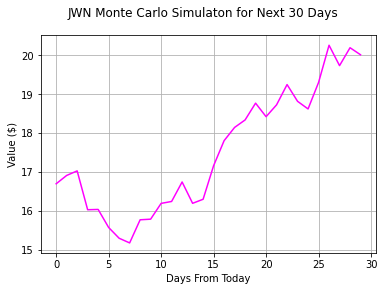

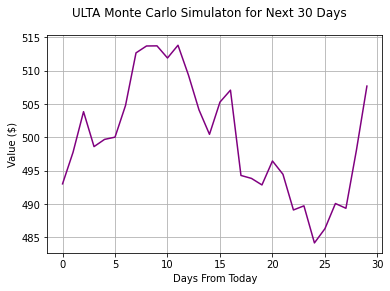

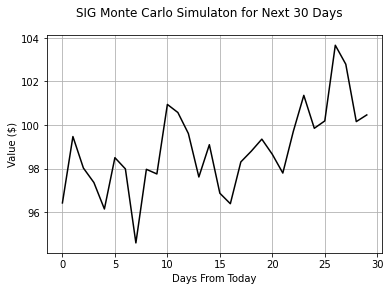

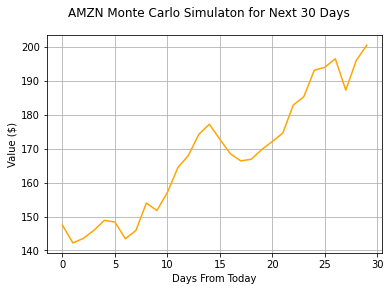

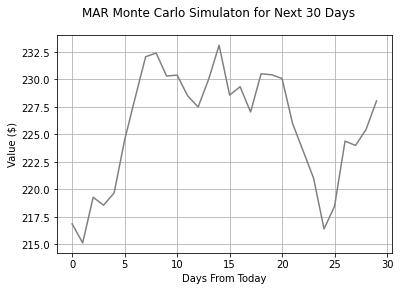

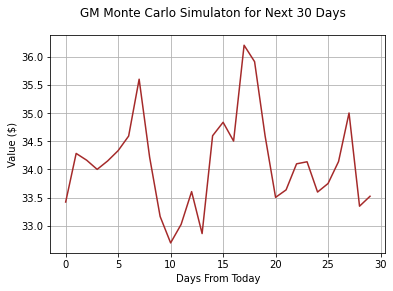

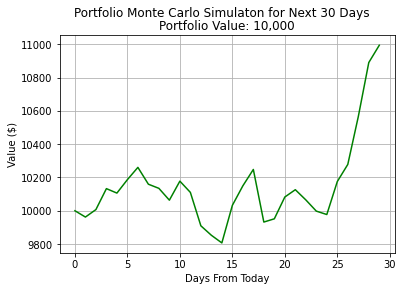

In [25]:
# initialize colors for plotting Monte Carlo simulations
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'purple', 'black', 'orange', 'gray', 'brown']
dict = {'Stock': [],
        'Starting Price': [],
       '30 Day Min': [],
       '30 Day Max': []}

for index, stock_ticker in enumerate(portfolio_tickers):
    # grab most recent stock data
    stock_data = si.get_data(stock_ticker).loc['2022-12-13':'2023-12-13'][['adjclose']]
    last_years_stock_data = stock_data.loc['2022-12-13':'2023-01-13']

    stock_multiplier = 1000/stock_data['adjclose'].iloc[0]
    stock_value = np.multiply(stock_data, stock_multiplier)
    
    last_years_stock_multiplier = 1000/last_years_stock_data['adjclose'].iloc[0]
    last_years_stock_value = np.multiply(last_years_stock_data, last_years_stock_multiplier)

    # if the first stock is being added to the portfolio, set the portfolio equal to the first stock
    if (stock_ticker == 'MAT'):
        last_years_portfolio_data = last_years_stock_value
        portfolio_data = stock_value
    
    # otherwise add the next stock to the portfolio
    else:
        last_years_portfolio_data = np.add(last_years_portfolio_data, last_years_stock_value)
        portfolio_data = np.add(portfolio_data, stock_value)
        
    # simulate price for 30 days from today using monte carlo and brownian motion
    min, max = calc_monte_carlo(stock_data, last_years_stock_data, stock_ticker, index, True)
    dict['Stock'].append(stock_ticker)
    dict['Starting Price'].append(round(stock_data['adjclose'].iloc[0], 2))
    dict['30 Day Min'].append(min)
    dict['30 Day Max'].append(max)

min, max = calc_monte_carlo(portfolio_data, last_years_portfolio_data, 'Portfolio', 1, False)
dict['Starting Price'].append(10000)
dict['Stock'].append('Portfolio')
dict['30 Day Min'].append(min)
dict['30 Day Max'].append(max)

## Minimum and Maximum Potential Return

In [26]:
min_max_df = pd.DataFrame.from_dict(dict)
min_max_df.head(11)

,Stock,Starting Price,30 Day Min,30 Day Max
0,MAT,17.46,18.42,27.30
1,HAS,57.67,47.03,62.34
2,M,20.63,14.30,29.83
3,TJX,77.94,87.09,103.57
4,JWN,16.69,13.31,21.06
5,ULTA,464.41,481.76,596.80
6,SIG,69.50,84.73,116.26
7,AMZN,92.49,121.72,200.71
8,MAR,161.42,187.13,243.87
9,GM,38.36,23.85,38.64


The Monte Carlo simulation presented in the graphs shows one possibility/draw for its performance over the next 30 days out of 1000 draws we calculated. To calculate the Monte Carlo simulations, we additionally ran a GARCH(1,1) model to analyze the historical volatility from a one year offset, such that our predicted price action also uses forecasted volatility. The table beside it shows the starting price of each stock within our portfolio and the overall portfolio. There, we show the end price we calculate for a single draw as well as a 30 day minimum and maximum price value based on the 5% and 95% predicted stock values at the end of this period.

### Are there any strategies you might suggest to mitigate risk in your portfolio? Discuss it here.

When looking at the Minimum/Maximum Potential Return table, we compare the original starting price to the 30 day min/max. An example of the Monte Carlo simulation’s single draw is also added. When making a portfolio, one way to mitigate risk is to invest in stocks that tend to have a 5% predicted minimum price that is close to the original starting price of the stock, meaning the stock is not likely to fall greatly during that period. Some stocks on our table like AMZN or TJX even have predicted 30 day minimum values greater than the original price of the stock.

It is also recommended to set stop loss orders to automatically sell stocks that fall below a certain price in order to limit potential losses. For example, if AMZN were to fall below 10%, a stop loss order could be triggered, executing a sale and thereby preventing further decline in the investment’s value. This strategy helps in managing risk and safeguarding the portfolio against significant downturns.

Additionally, investors would benefit from regularly analyzing market trends and economic indicators such as interest rate hikes that impact consumer spending behavior, which is especially impactful in the Consumer Discretionary sector. As much of our reasoning behind investing within this sector pertains to the time of year, this may help to distinguish if we expect the same growth as previous years or if there are special circumstances. In the event of a black swan event, being partially invested into assets such as bonds or certificates of deposit will decrease risk by earning a lower yield in exchange for protection in decreasing value.

It may also help to invest in a Consumer Discretionary mutual fund that holds more than 10 stocks. This will help diversify the portfolio so its performance is not as tightly tied to the performance of these specific stocks as well as decrease systemic risk. This still allows the investor to reap the benefits of investing within this sector and seeing the holiday spending stock growth.
